# Finite State Worlds

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator 

from pylab import cm
import pathlib

from lcs.agents import EnvironmentAdapter
from lcs import Perception

import gym
import gym_fsw

# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

In [2]:
# Import utils functions
%run utils/experiments.py
%run utils/metrics.py
%run utils/plots.py
%run utils/payoff_landscape.py
%run utils/basic_rl.py

In [3]:
# Plot settings
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

# Common color palette
palette = cm.get_cmap('Paired', 5)

COLORS = {
    'ACS2': palette(0),
    'AACS2_v1': palette(1),
    'AACS2_v2': palette(2),
    'Q-Learning': palette(3),
    'R-Learning': palette(4)
}

## Environment setup

In [4]:
env = gym.make('fsw-10-v0')
env.reset()

'0'

In [5]:
class FSWAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        return phenotype,

In [7]:
cache_prefix = f'{pathlib.Path().absolute()}/cache/{env.__class__.__name__}'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/reward-optimization-experiments/cache/FiniteStateWorld'

## Basic Metrics
Examine population size, rho parameter and exploitation capabilities.

In [8]:
# Params
learning_rate = 0.5
discount_factor = 0.95
epsilon = 0.1
zeta = 0.0001

# Set ACS2/AACS2 configuration parameter dictionary
basic_cfg = {
    'perception_bits': 1,
    'possible_actions': 2,
    'do_ga': False,
    'beta': learning_rate,
    'epsilon': epsilon,
    'gamma': discount_factor,
    'zeta': zeta,
    'environment_adapter': FSWAdapter,
    'user_metrics_collector_fcn': common_metrics,
    'biased_exploration_prob': 0,
    'metrics_trial_freq': 1
}

trials = 10_000
experiments = 10

In [9]:
%%time

p_acs2, p_aacs2v1, p_aacs2v2, agg_df = get_from_cache_or_run(
    f'{cache_prefix}/{trials}-trials-over-{experiments}-exp.dill',
    lambda: avg_experiments(experiments, fun=lambda: run_experiments_alternating(trials=trials, env=env, params=basic_cfg)))

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
CPU times: user 6min, sys: 179 ms, total: 6min
Wall time: 6min


In [10]:
agg_df

phase  steps_in_trial       rho  population  reliable
agent    trial                                                         
AACS2_v1 0      explore            13.9  0.008000        13.9       0.0
         1      exploit            13.9  0.008000        13.9       0.0
         2      explore            13.9  0.017990        14.8       0.0
         3      exploit            14.1  0.017990        14.8       0.0
         4      explore            13.9  0.026967        15.5       0.0
...                 ...             ...       ...         ...       ...
ACS2     9995   exploit            10.0  0.000000        40.0      40.0
         9996   explore            10.5  0.000000        40.0      40.0
         9997   exploit            10.0  0.000000        40.0      40.0
         9998   explore            10.7  0.000000        40.0      40.0
         9999   exploit            10.0  0.000000        40.0      40.0

[30000 rows x 5 columns]

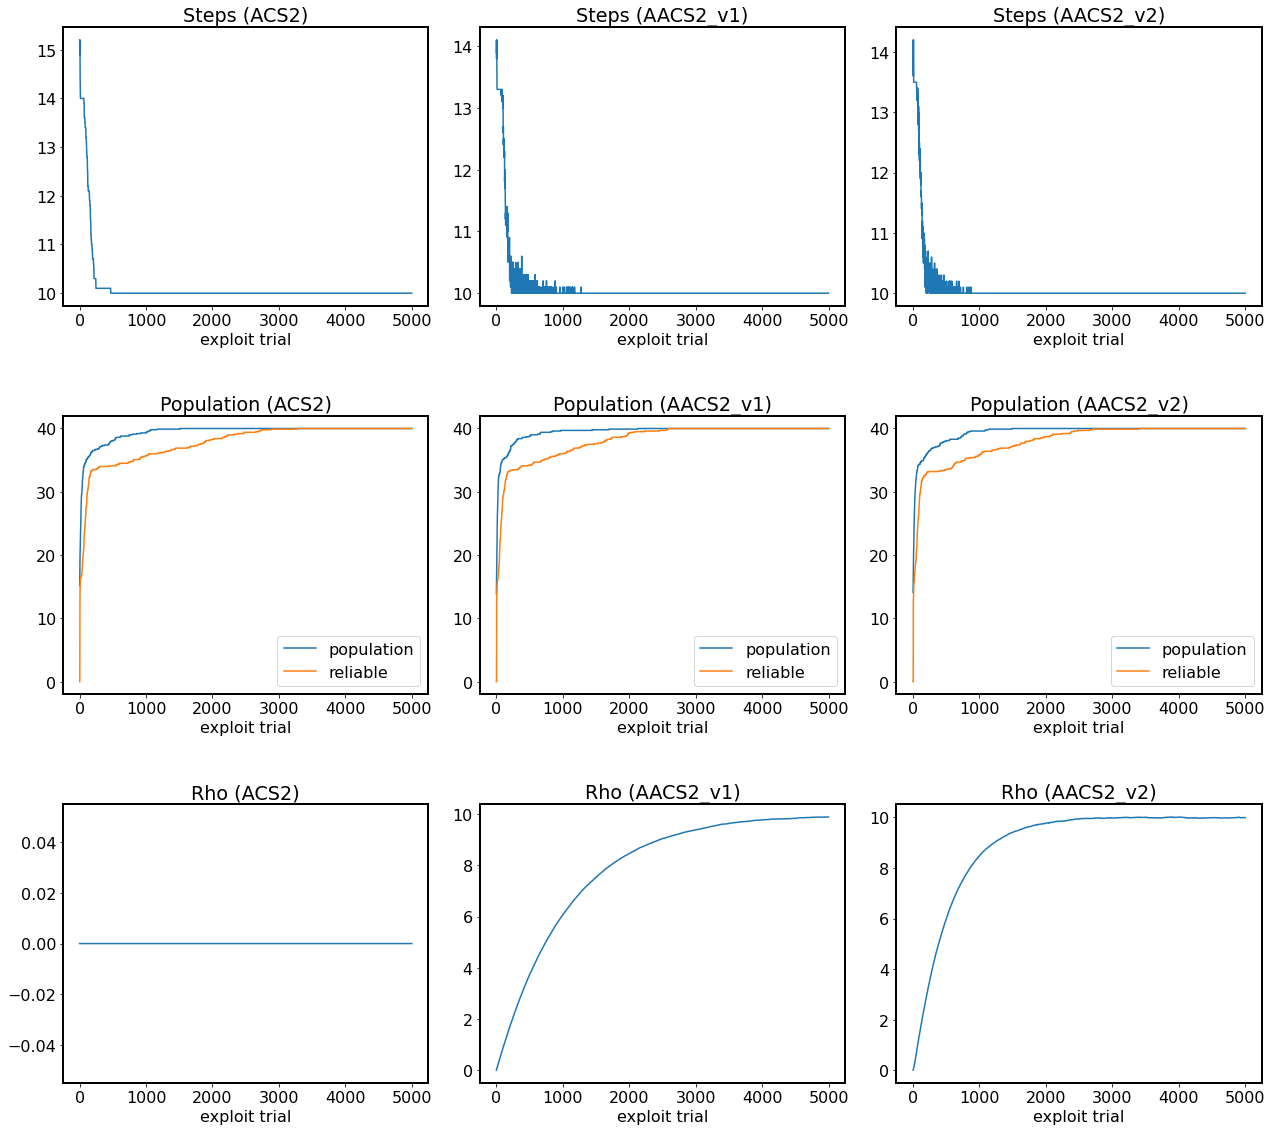

In [11]:
plot_exploit_results(agg_df)

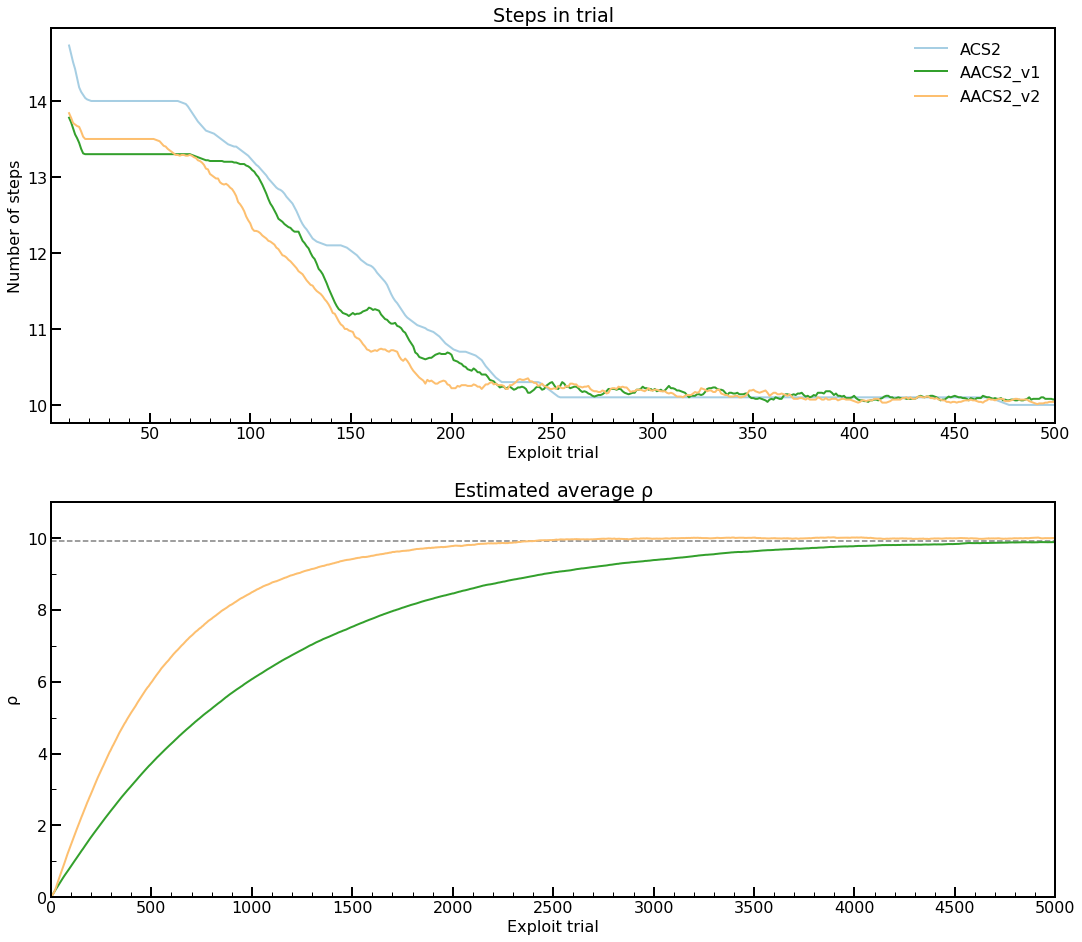

In [30]:
def plot_pop_and_rho(df):
    expl_df = df[df['phase'] == 'exploit']
    
    optimal_rho = 9.9
    xmax = trials/2
    
    fig, axs = plt.subplots(2, 1, figsize=(18, 16))
    
    # Steps in trial plot
    for alg in ['ACS2', 'AACS2_v1', 'AACS2_v2']:
        alg_df = expl_df.loc[alg]
        idx = pd.Index(name='exploit trial', data=np.arange(1, len(alg_df) + 1))
        alg_df.set_index(idx, inplace=True)
        
        alg_df['steps_in_trial'].rolling(window=10).mean().plot(ax=axs[0], label=alg, linewidth=2, color=COLORS[alg])
    
    axs[0].set_xlabel("Exploit trial")
    axs[0].set_xlim(1, 500)
    axs[0].xaxis.set_major_locator(MultipleLocator(50))
    axs[0].xaxis.set_minor_locator(MultipleLocator(10))
    axs[0].xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 
    axs[0].xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[0].xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    
    axs[0].set_ylabel("Number of steps")
    axs[0].yaxis.set_major_locator(MultipleLocator(1))
    axs[0].yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[0].yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    
    axs[0].set_title('Steps in trial')
    axs[0].legend(loc='upper right', frameon=False)
    
    # Rho plot
    for alg in ['AACS2_v1', 'AACS2_v2']:
        alg_df = expl_df.loc[alg]
        idx = pd.Index(name='exploit trial', data=np.arange(1, len(alg_df) + 1))
        alg_df.set_index(idx, inplace=True)
        
        alg_df['rho'].plot(ax=axs[1], label=alg, linewidth=2, color=COLORS[alg])
    
    axs[1].hlines(optimal_rho, 0, xmax, linestyles='dashed', alpha=0.5)
    
    axs[1].set_xlim(0, xmax)
    axs[1].set_xlabel("Exploit trial")
    axs[1].xaxis.set_major_locator(MultipleLocator(500))
    axs[1].xaxis.set_minor_locator(MultipleLocator(100))
    axs[1].xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 
    axs[1].xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[1].xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    
    axs[1].set_ylabel(r"$\mathregular{\rho}$")
    axs[1].yaxis.set_major_locator(MultipleLocator(2))
    axs[1].yaxis.set_minor_locator(MultipleLocator(1))
    axs[1].yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[1].yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    axs[1].set_ylim(0, 11)
    
    axs[1].set_title(r'Estimated average $\mathregular{\rho}$')
#     axs[1].legend(loc='lower right', frameon=False)
    
    plt.savefig('plots/fsw-steps_rho.pdf', transparent=False, bbox_inches='tight')
    
    
plot_pop_and_rho(agg_df)

## Payoff Landscape

In [31]:
state_action = get_all_state_action(env._state_action())
state_action[:10]

[StateAction(id=1, state='0', action=0),
 StateAction(id=2, state='0', action=1),
 StateAction(id=3, state='1', action=0),
 StateAction(id=4, state='1', action=1),
 StateAction(id=5, state='2', action=0),
 StateAction(id=6, state='2', action=1),
 StateAction(id=7, state='3', action=0),
 StateAction(id=8, state='3', action=1),
 StateAction(id=9, state='4', action=0),
 StateAction(id=10, state='4', action=1)]

### Data preparation

In [32]:
# Take first of each algorithm pass population for presenting payoff landscape 
pop_acs2 = p_acs2[0]
pop_aacs2v1 = p_aacs2v1[0]
pop_aacs2v2 = p_aacs2v2[0]

#### Q-learning

In [33]:
%%time

Q_init = np.zeros((env.observation_space.n, env.action_space.n))
Q = qlearning(env, trials, Q_init, epsilon, learning_rate, discount_factor)

CPU times: user 1.05 s, sys: 28 ms, total: 1.08 s
Wall time: 1.04 s


#### R-learning

In [34]:
%%time

R_init = np.zeros((env.observation_space.n, env.action_space.n))
R, rho = rlearning(env, trials, R_init, epsilon, learning_rate, zeta)

CPU times: user 1.59 s, sys: 120 ms, total: 1.71 s
Wall time: 1.58 s


In [35]:
rho

9.64638527595024

### Landscape plot

In [36]:
payoffs = {}

for sa in state_action:
    p = Perception((sa.state,))

    # ACS2
    acs2_match_set = pop_acs2.form_match_set(p)
    acs2_action_set = acs2_match_set.form_action_set(sa.action)

    # AACS2_v1
    aacs2v1_match_set = pop_aacs2v1.form_match_set(p)
    aacs2v1_action_set = aacs2v1_match_set.form_action_set(sa.action)

    # AACS2_v2
    aacs2v2_match_set = pop_aacs2v2.form_match_set(p)
    aacs2v2_action_set = aacs2v2_match_set.form_action_set(sa.action)

    # Check if all states are covered
    for alg, action_set in zip(['ACS2', 'AACS2_v1', 'AACS2_v2'],
                               [acs2_action_set, aacs2v1_action_set,
                                aacs2v2_action_set]):
        if len(action_set) == 0:
            print(f"WARN: No {alg} classifiers for perception: {p}, action: {sa.action}")

    payoffs[sa] = {
        'ACS2': np.mean(list(map(lambda cl: cl.r, acs2_action_set))),
        'AACS2_v1': np.mean(list(map(lambda cl: cl.r, aacs2v1_action_set))),
        'AACS2_v2': np.mean(list(map(lambda cl: cl.r, aacs2v2_action_set))),
        'Q-Learning': Q[int(sa.state), sa.action],
        'R-Learning': R[int(sa.state), sa.action]
    }

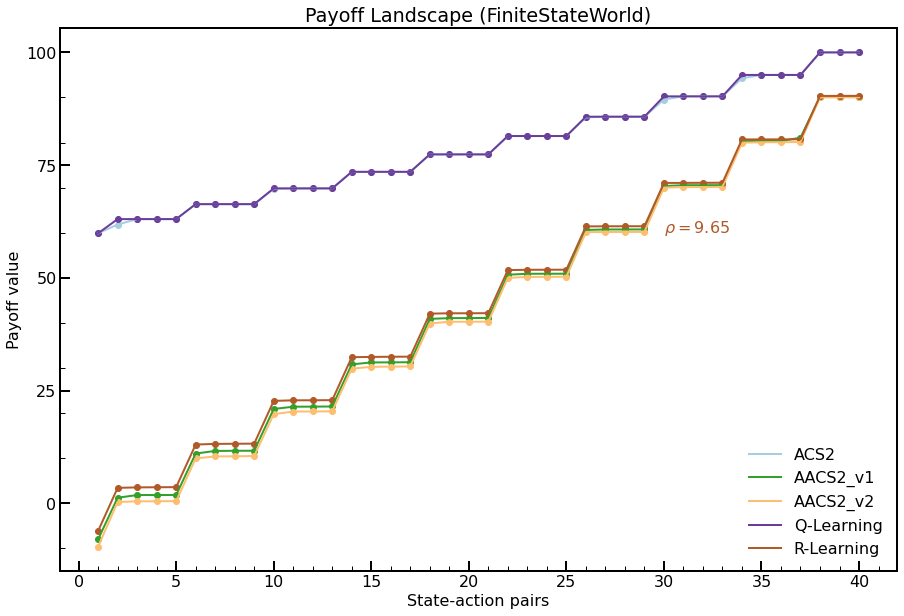

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))

x = range(1, len(payoffs)+1)

for alg in ['ACS2', 'AACS2_v1', 'AACS2_v2', 'Q-Learning', 'R-Learning']:
    y = sorted([v[alg] for k, v in payoffs.items()])
    
    plt.scatter(x, y, color=COLORS[alg])
    plt.plot(x, y, label=alg,  linewidth=2, color=COLORS[alg])

# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
ax.set_xlabel("State-action pairs")

# y-axis
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
ax.set_ylabel("Payoff value")

# others
ax.set_title(f"Payoff Landscape ({env.__class__.__name__})")
ax.text(30, 60, fr'$\rho={rho:.2f}$', color=COLORS['R-Learning'])
ax.legend(loc='lower right', bbox_to_anchor=(1, 0), frameon=False)

# save fig
plt.savefig('plots/fsw-payofflandscape.pdf', transparent=False, bbox_inches='tight')

#plt.show()